# Intro

Let's take a `.dat` file from `/manualReadings`. We have enough info to compute ozone in a manner similar to `ozone.py`.

1. angle is computed from wavelength value (interpolated A, C, D to regular mesh)
2. angle is rounded to get inc
3. inc should be within [0, 29] interval
4. inc is combined with instrument_constants and annual_constants from calibration-object
to produce N0, N1
    Note: calibration is an instance of class Calibration(ID), 
          where ID is Dobson ID, e.g. 103F, 31E
5. z (zenith angle) and mu (path length) are computed from calibration-object
6. 'ds'-computation is carried out if 
    mu<2.7 using N0, N1 for A and D waves
    mu<4. using N0, N1 for C and D waves
7. 'um'-computation is carried out using if-statements to select appropriate polynomial


In [75]:
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
from datetime import datetime as dt
import numpy as np


from astropy.time import Time
from astropy.coordinates import EarthLocation, get_sun, AltAz
import astropy.units as u

import autodobson

In [ ]:
def get_zenith(station, time):

        """
        Use astropy to obtain sun zenith angle at time, and station location
        """

        t = Time(time)
        l = EarthLocation(lat = station.lat * u.deg, lon = station.lon * u.deg, height = station.elevation * u.m)
        s = get_sun(t)
        s = s.transform_to(AltAz(obstime = t, location = l))
        z = s.zen.radian
        return z
    
    
def get_mu(station, zenith):

        """
        Calculate mu value, using station and sun information.
        """

        R   = station.radius
        r   = station.elevation
        h   = station.ozone_height
        SZA = zenith
        mu = (R + h) / np.sqrt(np.square(R + h) 
                               - np.square(R + r) * np.square(np.sin(SZA)))
        return mu

In [106]:
df = pd.read_csv('zozJan20.dat', 
            sep="\s+",
            names = ['year', 'month', 'day', 'hour', 'minute', 'second', 
                     'ob', 'dob', 'A1', 'A2', 'C1', 'C2', 'D1', 'D2']) 

df['dt']=pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])

# direct sun
ds = df[df['ob']==90].reset_index(drop = True)

# umkehr
um = df[df['ob']==95].reset_index(drop = True)

In [79]:
df

,year,month,day,hour,minute,second,ob,dob,A1,A2,C1,C2,D1,D2,dt
0,2020,1,1,9,14,7,90,031E,1979,1972,1179,1171,831,830,2020-01-01 09:14:07
1,2020,1,1,9,16,23,95,031E,1678,1676,826,834,448,457,2020-01-01 09:16:23
2,2020,1,1,10,23,34,95,031E,1548,1550,767,776,427,422,2020-01-01 10:23:34
3,2020,1,1,12,6,24,90,031E,1670,1669,1003,997,722,719,2020-01-01 12:06:24
4,2020,1,1,12,8,36,95,031E,1456,1454,701,725,387,399,2020-01-01 12:08:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2020,1,31,12,8,32,95,031E,1700,1700,923,921,563,562,2020-01-31 12:08:32
243,2020,1,31,13,59,43,95,031E,1661,1664,904,903,557,557,2020-01-31 13:59:43
244,2020,1,31,14,56,1,95,031E,1649,1650,893,892,549,548,2020-01-31 14:56:01
245,2020,1,31,17,52,52,95,031E,1926,1928,1039,1039,619,617,2020-01-31 17:52:52


In [329]:
# calibration constants for specific Dobson photometre
c = autodobson.Calibration('031E')

In [330]:
# geographical data about station
s = autodobson.Station(station = 'halley6a')

In [337]:
s

Halley VIa Auto Dobson station. Lat: -75.57, Lon: -25.47, Elevation: 30, Ozone Height: 18443.0

In [334]:
with open("annual_const.txt", 'w') as f: 
    for key, value in c.annual_constants.items(): 
        f.write('%s:%s\n' % (key, value))

In [164]:
# number of ds timesteps
N_ds = ds.shape[0]

In [180]:
# compute time, z and mu
T = []
z = []
mu = []
for i in range(N_ds):        
    T_i = pd.Timestamp.to_pydatetime(ds['dt'][i])
    z_i  = get_zenith(s, T_i)
    mu_i = get_mu(s, z_i)


    T.append(T_i)
    z.append(z_i)
    mu.append(mu_i)
    
mu = np.array(mu)
z = np.array(z)

In [338]:
# T

In [177]:
# compute N0, N1 for every wavelength
d = {}
for w in ['A', 'C', 'D']:
    d[w]={}
    d[w]['N0'] = []
    d[w]['N1'] = []

    for i in range(N_ds):

        angle = ds[w+'1'][i]/10 # because wavelength is on that order
        inc = int(np.floor(angle / 10))
        rn = 'R-N_'+w
        lo = 'Lo'+w

        N0 = (c.instrument_constants[rn][inc] +
             (angle / 10 - inc) *
                 (c.instrument_constants[rn][inc + 1] -
                  c.instrument_constants[rn][inc]))

        N1 = N0 + c.annual_constants[lo]

        d[w]['N0'].append(N0)
        d[w]['N1'].append(N1)
        
    d[w]['N0']=np.array(d[w]['N0'])
    d[w]['N1']=np.array(d[w]['N1'])

In [192]:
# AD expression: applies foer mu<2.7 
oz_AD  = ((d['A']['N1'] - d['D']['N1'])/mu/c.instrument_constants['ADcoeff']\
          - c.instrument_constants['ADbeta']) * 1000
oz_AD  = np.round(oz_AD)
oz_AD[mu>2.7]=None

In [193]:
# AD expression: applies foer mu<4. somehow
oz_CD  = ((d['C']['N1'] - d['D']['N1'])/mu/c.instrument_constants['CDcoeff']\
       - c.instrument_constants['CDbeta']) * 1000 +\
       c.annual_constants['CDDS_offset']
oz_CD  = np.round(oz_CD)
oz_CD[mu>4.]=None

In [225]:
ds['AD'] = oz_AD
ds['CD'] = oz_CD
ds['z'] = z
ds['mu'] = mu

In [292]:
ds_mean = ds.groupby(['year', 'month', 'day'])\
.mean()\
.reset_index()\
[['day','AD','CD', 'mu']]

In [293]:
ds_mean

,day,AD,CD,mu
0,1,292.750000,297.600000,2.085428
1,2,299.000000,300.500000,1.659482
2,4,302.500000,304.500000,1.885236
3,5,314.000000,314.333333,1.850070
4,7,309.000000,312.000000,2.082739
5,8,306.000000,317.000000,1.690903
6,9,301.500000,305.222222,1.968848
7,10,293.000000,298.500000,1.723329
8,23,269.000000,280.000000,2.464294
9,25,271.333333,275.333333,1.990238


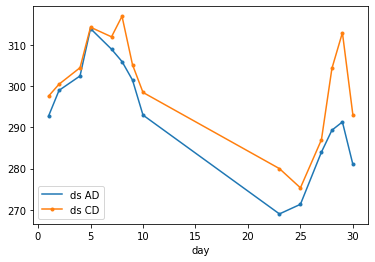

In [266]:
ax = ds_mean.plot(x = 'day', y = 'AD', style = '.-', label = 'ds AD')
ds_mean.plot(x = 'day', y = 'CD', style = '.-', label = 'ds CD', ax = ax);

In [270]:
c=pd.read_csv('https://legacy.bas.ac.uk/met/jds/ozone/data/ZYDATA19M.DAT',
             sep="\s+",)

In [275]:
c.query('MM==1').plot(x = 'DD', y = 'XXX', ax = ax)

<AxesSubplot:xlabel='DD'>

In [299]:
c.columns

Index(['MM', 'DD', 'JJJJJ', 'XXX', 'SD', 'N', 'MU', 'HOUR', 'SPAN'], dtype='object')

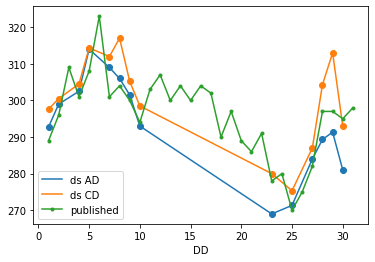

In [284]:
ax = ds_mean.plot(x = 'day', y = 'AD', style = 'o-', label = 'ds AD')
ds_mean.plot(x = 'day', y = 'CD', style = 'o-', label = 'ds CD', ax = ax);
c.query('MM==1').plot(x = 'DD', y = 'XXX', ax = ax, label = 'published', style = '.-');

In [286]:
c.query('MM==1')

,MM,DD,JJJJJ,XXX,SD,N,MU,HOUR,SPAN
26,1,1,43830,289,3,24,2.03,1.98,718
27,1,2,43831,296,9,17,2.25,0.77,1235
28,1,3,43832,309,4,11,2.66,2.07,1406
29,1,4,43833,301,5,18,2.09,2.75,702
30,1,5,43834,308,7,22,2.25,0.90,1434
31,1,6,43835,323,4,8,2.52,4.94,750
32,1,7,43836,301,3,15,2.03,3.23,672
33,1,8,43837,304,9,21,2.24,2.45,1266
34,1,9,43838,300,5,50,2.26,2.35,1433
35,1,10,43839,294,6,19,2.06,2.78,869


<AxesSubplot:xlabel='day'>

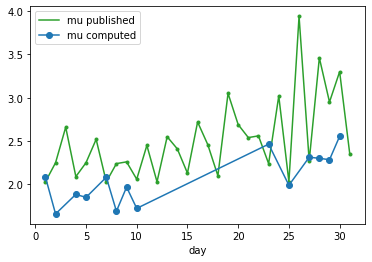

In [298]:
ax = c.query('MM==1')[['DD','MU']].plot('DD', 'MU', label = 'mu published', style = '.-', 
                                       color = 'tab:green')
ds_mean.plot('day', 'mu', ax = ax, label = 'mu computed', style = 'o-')

In [303]:
# Load Jon's calculation
d=pd.read_csv('https://legacy.bas.ac.uk/met/jds/ozone/data/ZXDATA19M.DAT',
             sep="\s+",
              names = ['month', 'day', 'hour','minute', 'time_code', 
                       'mu', 'z', 
                       'obs_type', 'dobs_code', 
                       'ozone'])
d['year']=2019*(d['month']==12)+2020*(d['month']==1)+2020*(d['month']==2)
d['dt']=pd.to_datetime(d[['year', 'month', 'day', 'hour', 'minute']])
d

,month,day,hour,minute,time_code,mu,z,obs_type,dobs_code,ozone,year,dt
0,12,6,21,32,43804.397,3.732,75.12,6,22,322,2019,2019-12-06 21:32:00
1,12,6,21,32,43804.397,3.732,75.12,7,22,315,2019,2019-12-06 21:32:00
2,12,6,23,44,43804.489,5.436,80.41,6,25,316,2019,2019-12-06 23:44:00
3,12,7,9,15,43804.886,2.099,61.89,5,95,326,2019,2019-12-07 09:15:00
4,12,7,9,15,43804.886,2.099,61.89,6,95,331,2019,2019-12-07 09:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...
975,2,1,9,22,43860.891,2.620,68.00,6,95,352,2020,2020-02-01 09:22:00
976,2,1,11,55,43860.997,2.012,60.52,5,95,302,2020,2020-02-01 11:55:00
977,2,1,11,55,43860.997,2.012,60.52,6,95,319,2020,2020-02-01 11:55:00
978,2,1,12,19,43861.014,1.968,59.77,5,95,299,2020,2020-02-01 12:19:00


In [317]:
d[d['obs_type']==1]

,month,day,hour,minute,time_code,mu,z,obs_type,dobs_code,ozone,year,dt
17,12,7,17,57,43805.248,2.120,62.20,1,90,329,2019,2019-12-07 17:57:00
22,12,7,20,54,43805.371,3.306,72.97,1,90,322,2019,2019-12-07 20:54:00
31,12,8,11,58,43805.999,1.702,54.26,1,90,327,2019,2019-12-08 11:58:00
36,12,8,13,28,43806.062,1.647,52.86,1,90,316,2019,2019-12-08 13:28:00
43,12,8,14,30,43806.105,1.666,53.35,1,90,323,2019,2019-12-08 14:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...
932,1,28,17,56,43857.248,2.352,65.22,1,90,288,2020,2020-01-28 17:56:00
939,1,29,9,24,43857.892,2.521,67.05,1,90,284,2020,2020-01-29 09:24:00
941,1,29,12,12,43858.009,1.933,59.15,1,90,287,2020,2020-01-29 12:12:00
949,1,29,18,0,43858.250,2.393,65.69,1,90,299,2020,2020-01-29 18:00:00


<AxesSubplot:xlabel='dt'>

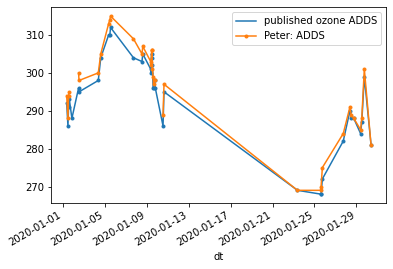

In [328]:
ax = d.query('obs_type ==1 and month == 1')\
    .plot(x = 'dt', y = 'ozone', label = 'published ozone ADDS', style = '.-')
ds.plot(x = 'dt', y = 'AD', ax = ax, label = 'Peter: ADDS', style = '.-')
# ds.plot(x = 'dt', y = 'CD', ax = ax, label = 'Peter: CDDS')

In [312]:
d

,month,day,hour,minute,time_code,mu,z,obs_type,dobs_code,ozone,year,dt
0,12,6,21,32,43804.397,3.732,75.12,6,22,322,2019,2019-12-06 21:32:00
1,12,6,21,32,43804.397,3.732,75.12,7,22,315,2019,2019-12-06 21:32:00
2,12,6,23,44,43804.489,5.436,80.41,6,25,316,2019,2019-12-06 23:44:00
3,12,7,9,15,43804.886,2.099,61.89,5,95,326,2019,2019-12-07 09:15:00
4,12,7,9,15,43804.886,2.099,61.89,6,95,331,2019,2019-12-07 09:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...
975,2,1,9,22,43860.891,2.620,68.00,6,95,352,2020,2020-02-01 09:22:00
976,2,1,11,55,43860.997,2.012,60.52,5,95,302,2020,2020-02-01 11:55:00
977,2,1,11,55,43860.997,2.012,60.52,6,95,319,2020,2020-02-01 11:55:00
978,2,1,12,19,43861.014,1.968,59.77,5,95,299,2020,2020-02-01 12:19:00


In [313]:
['dt']

514   2020-01-01 09:14:00
515   2020-01-01 09:14:00
516   2020-01-01 09:16:00
517   2020-01-01 09:16:00
518   2020-01-01 10:23:00
              ...        
968   2020-01-31 14:56:00
969   2020-01-31 14:56:00
970   2020-01-31 17:52:00
971   2020-01-31 17:52:00
972   2020-01-31 21:09:00
Name: dt, Length: 459, dtype: datetime64[ns]

In [310]:
ds['dt']


0    2020-01-01 09:14:07
1    2020-01-01 12:06:24
2    2020-01-01 13:34:32
3    2020-01-01 15:19:00
4    2020-01-01 21:09:19
5    2020-01-02 12:26:01
6    2020-01-02 13:27:35
7    2020-01-04 09:31:01
8    2020-01-04 15:10:02
9    2020-01-05 09:09:58
10   2020-01-05 11:59:23
11   2020-01-05 13:31:50
12   2020-01-07 17:57:27
13   2020-01-08 13:28:29
14   2020-01-08 15:17:54
15   2020-01-09 09:24:44
16   2020-01-09 10:09:48
17   2020-01-09 11:25:14
18   2020-01-09 12:01:57
19   2020-01-09 13:21:46
20   2020-01-09 14:57:01
21   2020-01-09 15:58:44
22   2020-01-09 18:07:11
23   2020-01-09 19:56:02
24   2020-01-10 13:36:48
25   2020-01-10 15:50:57
26   2020-01-23 09:09:10
27   2020-01-25 14:07:11
28   2020-01-25 15:07:55
29   2020-01-25 18:02:23
30   2020-01-27 17:52:18
31   2020-01-28 09:07:04
32   2020-01-28 11:58:26
33   2020-01-28 17:56:41
34   2020-01-29 09:24:37
35   2020-01-29 12:12:20
36   2020-01-29 18:00:30
37   2020-01-30 09:24:00
Name: dt, dtype: datetime64[ns]

In [ ]:
ax = d.query('month==1')[['DD','MU']].plot('DD', 'MU', label = 'mu published', style = '.-', 
                                       color = 'tab:green')
ds_mean.plot('day', 'mu', ax = ax, label = 'mu computed', style = 'o-')